拍照(獲取外參數) 已預先處理畸變校正

In [5]:
#照片存在資料夾picture，並且自動清除舊照片
import cv2
import threading
import numpy as np
import time
import os

# 相機校正參數 
# Camera 1
camera_matrix_1 = np.array([[2.00360408e+03, 0.00000000e+00, 9.25242081e+02],
                            [0.00000000e+00, 1.50411453e+03, 5.29417906e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

dist_coeffs_1 = np.array( [ 4.63559055e-03, -5.89700965e-01,  5.09270412e-05,  2.11691149e-03,1.88317468e+00])

# Camera 2
camera_matrix_2 = np.array([[1.97386030e+03, 0.00000000e+00, 8.99068057e+02],
                            [0.00000000e+00, 1.48037743e+03, 5.62805759e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist_coeffs_2 = np.array([ 1.44373320e-01, -2.83192799e+00, -3.66737222e-03,  4.73604559e-04, 1.23743308e+01])

# Camera 3
camera_matrix_3 = np.array([[1.98807867e+03, 0.00000000e+00, 9.54628263e+02],
                            [0.00000000e+00, 1.48698973e+03, 5.75289864e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist_coeffs_3 = np.array([ 4.87647738e-02, -1.42206998e+00,  2.63301440e-04,  3.75294232e-03, 5.23169573e+00])

# 校正函式
def undistort_image(image, K, dist):
    h, w = image.shape[:2]
    new_K, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))
    return cv2.undistort(image, K, dist, None, new_K)

# 多執行緒 RTSP 讀取類別
class RTSPCamera:
    def __init__(self, url, name="Camera"):
        self.url = url
        self.name = name
        self.frame = None
        self.capture = cv2.VideoCapture(url)
        self.running = True
        self.lock = threading.Lock()

    def start(self):
        thread = threading.Thread(target=self.update, daemon=True)
        thread.start()

    def update(self):
        while self.running:
            if not self.capture.isOpened():
                time.sleep(0.1)
                continue
            try:
                ret, frame = self.capture.read()
                if ret:
                    with self.lock:
                        self.frame = frame
                else:
                    print(f"[{self.name}] 無法讀取影像，略過此幀")
            except Exception as e:
                print(f"[{self.name}] 發生錯誤：{e}")
                self.running = False

    def read(self):
        with self.lock:
            try:
                return self.frame.copy() if self.frame is not None else None
            except Exception as e:
                print(f"[{self.name}] frame 讀取錯誤：{e}")
                return None

    def stop(self):
        self.running = False
        time.sleep(0.2)  # 等待執行緒結束 update() 迴圈
        if self.capture.isOpened():
            self.capture.release()

# 建立儲存資料夾
save_dir = "picture"
# 若資料夾已存在，刪除裡面所有檔案
if os.path.exists(save_dir):
    for f in os.listdir(save_dir):
        file_path = os.path.join(save_dir, f)
        if os.path.isfile(file_path):
            os.remove(file_path)
else:            
    os.makedirs(save_dir, exist_ok=True)

rtsp_url_1 = "rtsp://192.168.0.80:8554/stream1"
rtsp_url_2 = "rtsp://192.168.0.80:8554/stream2"
rtsp_url_3 = "rtsp://192.168.0.80:8554/stream3"

# 標記名稱
cam1 = RTSPCamera(rtsp_url_1, "cam1")
cam2 = RTSPCamera(rtsp_url_2, "cam2")
cam3 = RTSPCamera(rtsp_url_3, "cam3")

cam1.start()
cam2.start()
cam3.start()

# 初始設定
max_captures = 1
capture_interval = 1  # 秒
img_counter = 0
last_capture_time = time.time()

# 主迴圈
while True:
    frame1 = cam1.read()
    frame2 = cam2.read()
    frame3 = cam3.read()

    if frame1 is not None:
        undistorted1 = undistort_image(frame1, camera_matrix_1, dist_coeffs_1)
        cv2.imshow("cam1", cv2.resize(undistorted1, (640, 360)))
    else:
        undistorted1 = None

    if frame2 is not None:
        undistorted2 = undistort_image(frame2, camera_matrix_2, dist_coeffs_2)
        cv2.imshow("cam2", cv2.resize(undistorted2, (640, 360)))
    else:
        undistorted2 = None

    if frame3 is not None:
        undistorted3 = undistort_image(frame3, camera_matrix_3, dist_coeffs_3)
        cv2.imshow("cam3", cv2.resize(undistorted3, (640, 360)))
    else:
        undistorted3 = None

    current_time = time.time()

    if current_time - last_capture_time >= capture_interval:
        if undistorted1 is not None and undistorted2 is not None and undistorted3 is not None:
           
            cv2.imwrite(os.path.join(save_dir, f"cam1.jpg"), undistorted1)
            cv2.imwrite(os.path.join(save_dir, f"cam2.jpg"), undistorted2)
            cv2.imwrite(os.path.join(save_dir, f"cam3.jpg"), undistorted3)
            print(f"已儲存校正後影像組 #{img_counter + 1}")
            img_counter += 1
            last_capture_time = current_time

        if img_counter >= max_captures:
            print("已達最大擷取數，程式即將結束")
            break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("使用者中止擷取")
        break

# 關閉攝影機與視窗
cam1.stop()
cam2.stop()
cam3.stop()

# 釋放
time.sleep(1)

cv2.destroyAllWindows()


已儲存校正後影像組 #1
已達最大擷取數，程式即將結束


獲取平移向量及旋轉矩陣  by ArUco 標記

In [6]:
import cv2
import numpy as np
import json
import pickle
import os
import time

# 攝影機參數
camera_params = {
    "cam1": {
        "camera_matrix": np.array([
            [2.00360408e+03, 0.00000000e+00, 9.25242081e+02],
            [0.00000000e+00, 1.50411453e+03, 5.29417906e+02],
            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
            ]),
        "dist_coeffs": np.zeros(5)  # 已經校正，使用零畸變係數
    },
    "cam2": {
        "camera_matrix": np.array([
            [1.97386030e+03, 0.00000000e+00, 8.99068057e+02],
            [0.00000000e+00, 1.48037743e+03, 5.62805759e+02],
            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
        ]),
        "dist_coeffs": np.zeros(5)  
    },
    "cam3": {
        "camera_matrix": np.array([
            [1.98807867e+03, 0.00000000e+00, 9.54628263e+02],
            [0.00000000e+00, 1.48698973e+03, 5.75289864e+02],
            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
        ]),
        "dist_coeffs": np.zeros(5)  
    }
}

# ArUco 設定 
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
parameters = cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
detector = cv2.aruco.ArucoDetector(dictionary, parameters)

# 標記尺寸
marker_size = 0.1  # 以公尺為單位 

# 定義全域變數
target_marker_id = 19  # 目標標記ID
camera_data = {}  # 儲存相機資料
marker_positions = {}  # 儲存標記位置

# 偵測圖像中的 ArUco 標記 
def detect_markers_in_image(image, cam_name):
    if image is None:
        return None, {}
    
    # 獲取相機參數
    camera_matrix = camera_params[cam_name]["camera_matrix"]
    dist_coeffs = camera_params[cam_name]["dist_coeffs"]
    
    # 轉換為灰階
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 偵測 ArUco 標記
    corners, ids, _ = detector.detectMarkers(gray)
    
    # 顯示影像
    display = image.copy()
    cv2.putText(display, cam_name, (30, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    marker_data = {}
    
    if ids is not None and len(ids) > 0:
        cv2.aruco.drawDetectedMarkers(display, corners, ids)
        
        for i in range(len(corners)):
            marker_id = int(ids[i][0])
            
            # 創建標記的3D點
            objPoints = np.array([
                [-marker_size/2, marker_size/2, 0],
                [marker_size/2, marker_size/2, 0],
                [marker_size/2, -marker_size/2, 0],
                [-marker_size/2, -marker_size/2, 0]
            ])
            
            # 獲取標記的2D角點
            imgPoints = corners[i][0].astype(np.float64)
            
            # 使用solvePnP查找關鍵點
            success, rvec, tvec = cv2.solvePnP(
                objPoints, imgPoints, camera_matrix, dist_coeffs
            )
            
            if success:
                # 繪製坐標軸
                cv2.drawFrameAxes(display, camera_matrix, dist_coeffs, 
                                rvec, tvec, 0.05)
                
                # 儲存標記數據
                marker_data[marker_id] = {
                    "corners": corners[i],
                    "rvec": rvec,
                    "tvec": tvec,
                    "timestamp": time.time()
                }
                
                # 顯示資訊
                distance = np.linalg.norm(tvec)
                cv2.putText(display, f"ID: {marker_id} Dist: {distance:.2f}m", 
                            (int(corners[i][0][0][0]), int(corners[i][0][0][1]) - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                
                # 標記目標ID
                if marker_id == target_marker_id:
                    center_x = int(np.mean([p[0] for p in corners[i][0]]))
                    center_y = int(np.mean([p[1] for p in corners[i][0]]))
                    cv2.circle(display, (center_x, center_y), 15, (0, 0, 255), 3)
                    cv2.putText(display, f"Target ID: {marker_id}", 
                                (center_x + 20, center_y), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    return display, marker_data

# 計算相機外參數 
def calculate_camera_extrinsics(camera_data):
    """
    Args:
        camera_data: 包含每個相機偵測到的標記數據的字典
    Returns:
        camera_extrinsics: 外參數的字典
    """
    print("計算相機外參數...")
    
    # 初始化相機外參數
    camera_extrinsics = {
        "cam1": {
            "R": np.eye(3),  # 作為參考坐標系，使用單位矩陣
            "t": np.zeros((3, 1)),  # 作為原點
            "world_position": np.zeros(3)  # 世界座標位置
        }
    }
    
    # 收集所有標記的數據
    marker_observations = {}
    
    for cam_name, data in camera_data.items():
        markers = data.get("markers", {})
        
        for marker_id, marker_info in markers.items():
            if marker_id not in marker_observations:
                marker_observations[marker_id] = {}
            
            marker_observations[marker_id][cam_name] = marker_info
    
    # 找出至少兩台相機都觀察到的標記
    shared_markers = {}
    
    for marker_id, observations in marker_observations.items():
        if len(observations) >= 2 and "cam1" in observations:  # 確保 cam1 有觀察到
            shared_markers[marker_id] = observations
    
    if not shared_markers:
        print("沒有找到共享標記，無法計算外參數")
        return None
    
    # 使用共享標記計算相對於cam1的外參數
    for cam_name in ["cam2", "cam3"]:
        if cam_name not in camera_data:
            print(f"相機 {cam_name} 數據不存在，無法計算外參數")
            continue
        
        # 使用所有共享標記來計算平均外參數
        r_matrices = []
        t_vectors = []
        
        for marker_id, observations in shared_markers.items():
            if cam_name in observations and "cam1" in observations:
                # 獲取cam1的標記信息
                ref_marker_info = observations["cam1"]
                ref_rvec = ref_marker_info["rvec"]
                ref_tvec = ref_marker_info["tvec"]
                
                # 將cam1的旋轉向量轉換為旋轉矩陣
                ref_Rmat, _ = cv2.Rodrigues(ref_rvec)
                
                # 獲取當前相機的標記信息
                marker_info = observations[cam_name]
                rvec = marker_info["rvec"]
                tvec = marker_info["tvec"]
                
                # 將旋轉向量轉換為旋轉矩陣
                Rmat, _ = cv2.Rodrigues(rvec)
                
                # 計算相對位置
                R_rel = Rmat @ ref_Rmat.T
                t_rel = tvec - R_rel @ ref_tvec
                
                r_matrices.append(R_rel)
                t_vectors.append(t_rel)
        
        if r_matrices and t_vectors:
            # 計算平均旋轉矩陣和平移向量
            # 平均 ps:近似
            R_avg = np.mean(r_matrices, axis=0)
            t_avg = np.mean(t_vectors, axis=0)
            
            # 確保旋轉矩陣是正交的
            u, _, vh = np.linalg.svd(R_avg)
            R_ortho = u @ vh
            
            # 計算相機在世界坐標系中的位置
            world_pos = -R_ortho.T @ t_avg
            
            # 儲存外參數
            camera_extrinsics[cam_name] = {
                "R": R_ortho,
                "t": t_avg,
                "world_position": world_pos.flatten()
            }
            
            print(f"相機 {cam_name} 外參數計算完成")
            print(f"  位置: {world_pos.flatten()}")
        else:
            print(f"無法為相機 {cam_name} 計算外參數，未找到足夠共享標記")
    
    return camera_extrinsics

# 保存相機外參數 
def save_camera_extrinsics(camera_extrinsics, base_dir=r""):
    pkl_path = os.path.join(base_dir, "camera_extrinsics.pkl")#檔案名稱camera_extrinsics
    json_path = os.path.join(base_dir, "camera_extrinsics.json")
    
    # 保存文件
    with open(pkl_path, 'wb') as f:
        pickle.dump(camera_extrinsics, f)
    
    # 保存為 JSON 文件
    json_data = {}
    for cam_name, data in camera_extrinsics.items():
        json_data[cam_name] = {
            "R": data["R"].tolist(),
            "t": data["t"].flatten().tolist(),
            "world_position": data["world_position"].tolist() if "world_position" in data else (-data["R"].T @ data["t"]).flatten().tolist()
        }
    
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"相機外參數已保存到:")
    print(f"  {pkl_path}")
    print(f"  {json_path}")

# 三角測量函數 
def triangulate_markers(camera_data, camera_extrinsics):
    # 檢查是否至少有兩台相機有數據
    if len(camera_data) < 2:
        print("可用相機不足，無法進行三角測量")
        return {}
    
    # 收集所有標記的觀測數據
    marker_observations = {}
    
    for cam_name, data in camera_data.items():
        markers = data.get("markers", {})
        
        for marker_id, marker_info in markers.items():
            if marker_id not in marker_observations:
                marker_observations[marker_id] = {}
            
            marker_observations[marker_id][cam_name] = marker_info
    
    # 記錄三角測量結果
    marker_positions = {}
    
    # 對每個被至少兩台相機觀測到的標記進行三角測量
    for marker_id, observations in marker_observations.items():
        if len(observations) >= 2:  # 至少需要兩台相機
            # 嘗試所有相機對
            cam_names = list(observations.keys())
            
            # 儲存所有相機對的測量結果
            all_measurements = []
            
            # 嘗試所有相機對組合
            for i in range(len(cam_names)):
                for j in range(i+1, len(cam_names)):
                    cam1_name = cam_names[i]
                    cam2_name = cam_names[j]
                    
                    # 檢查兩台相機是否都存在於外參數中
                    if cam1_name not in camera_extrinsics or cam2_name not in camera_extrinsics:
                        print(f"警告：缺少 {cam1_name} 或 {cam2_name} 的外參數")
                        continue
                    
                    # 獲取相機參數
                    K1 = camera_params[cam1_name]["camera_matrix"]
                    R1 = camera_extrinsics[cam1_name]["R"]
                    t1 = camera_extrinsics[cam1_name]["t"]
                    
                    K2 = camera_params[cam2_name]["camera_matrix"]
                    R2 = camera_extrinsics[cam2_name]["R"]
                    t2 = camera_extrinsics[cam2_name]["t"]
                    
                    # 確保 t 矩陣正確
                    if t1.shape != (3, 1):
                        if len(t1.shape) == 1:
                            t1 = t1.reshape(3, 1)
                        else:
                            t1 = t1.T
                    
                    if t2.shape != (3, 1):
                        if len(t2.shape) == 1:
                            t2 = t2.reshape(3, 1)
                        else:
                            t2 = t2.T
                    
                    # 創建投影矩陣 P = K[R|t]
                    Rt1 = np.hstack((R1, t1))
                    P1 = K1 @ Rt1
                    
                    Rt2 = np.hstack((R2, t2))
                    P2 = K2 @ Rt2
                    
                    # 獲取2D點
                    corners1 = observations[cam1_name]["corners"][0]
                    corners2 = observations[cam2_name]["corners"][0]
                    
                    # 使用四個角點進行更準確的三角測量
                    point_3d_all = np.zeros((4, 3))
                    
                    for corner_idx in range(4):
                        point1 = corners1[corner_idx].astype(np.float64)
                        point2 = corners2[corner_idx].astype(np.float64)
                        
                        # 執行三角測量
                        point_4d = cv2.triangulatePoints(P1, P2, point1, point2)
                        
                        # 從齊次坐標轉換為3D坐標
                        point_3d = (point_4d[:3] / point_4d[3]).flatten()
                        point_3d_all[corner_idx] = point_3d
                    
                    # 計算標記中心點作為最終位置
                    marker_center_3d = np.mean(point_3d_all, axis=0)
                    
                    # 添加到測量結果
                    all_measurements.append({
                        "position": marker_center_3d,
                        "corners_3d": point_3d_all,
                        "cam_pair": (cam1_name, cam2_name)
                    })
                    
                    print(f"相機對 {cam1_name}-{cam2_name} 測量標記 {marker_id}:")
                    print(f"  位置: X={marker_center_3d[0]:.6f}, Y={marker_center_3d[1]:.6f}, Z={marker_center_3d[2]:.6f}")
            
            # 如果有測量結果，計算平均位置
            if all_measurements:
                # 先使用一對相機
                best_measurement = all_measurements[0]
                
                # 儲存結果
                marker_positions[marker_id] = {
                    "position": best_measurement["position"],
                    "corners_3d": best_measurement["corners_3d"],
                    "timestamp": time.time(),
                    "cam_pair": best_measurement["cam_pair"]
                }
                
                print(f"標記 {marker_id} 最終測量結果:")
                print(f"  位置: X={best_measurement['position'][0]:.6f}, Y={best_measurement['position'][1]:.6f}, Z={best_measurement['position'][2]:.6f}")
                print(f"  使用相機對: {best_measurement['cam_pair'][0]}-{best_measurement['cam_pair'][1]}")
                
                # 檢查是否為目標標記
                if marker_id == target_marker_id:
                    print(f"找到目標標記 ID {target_marker_id}！")
    
    return marker_positions

#  保存目標標記資料的函數 
def save_target_marker_data(marker_positions, camera_data):
    """保存目標標記資料到ArUco資料夾"""
    # 確認是否找到目標標記
    if target_marker_id not in marker_positions:
        print(f"未找到目標標記 ID {target_marker_id}，無法保存")
        return False
    
    # 創建資料夾
    folder_name = r"ArUco"
    try:
        os.makedirs(folder_name, exist_ok=True)
        print(f"已創建資料夾: {folder_name}")
    except Exception as e:
        print(f"創建資料夾時出錯: {str(e)}")
        return False
    
    # 獲取目標標記資料
    target_data = marker_positions[target_marker_id]
    
    # 創建JSON資料
    marker_json = {
        "marker_id": target_marker_id,
        "position": target_data["position"].tolist(),
        "corners_3d": target_data["corners_3d"].tolist(),
        "timestamp": target_data["timestamp"],
        "cam_pair": target_data["cam_pair"],
        "datetime": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # 保存為JSON檔案
    json_file = os.path.join(folder_name, f"marker_{target_marker_id}_position.json")
    with open(json_file, 'w') as f:
        json.dump(marker_json, f, indent=2)
    print(f"目標標記 ID {target_marker_id} 位置已保存到 {json_file}")
    
    # 保存分析
    report_file = os.path.join(folder_name, f"marker_{target_marker_id}_report.txt")
    with open(report_file, 'w') as f:
        f.write(f"=== ArUco 標記 ID {target_marker_id} 三角測量報告 ===\n\n")
        f.write(f"測量時間: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"使用相機對: {target_data['cam_pair'][0]}-{target_data['cam_pair'][1]}\n\n")
        f.write(f"位置座標:\n")
        f.write(f"X: {target_data['position'][0]:.6f} 公尺\n")
        f.write(f"Y: {target_data['position'][1]:.6f} 公尺\n")
        f.write(f"Z: {target_data['position'][2]:.6f} 公尺\n\n")
        f.write(f"四個角點座標:\n")
        for i, corner in enumerate(target_data['corners_3d']):
            f.write(f"角點 {i+1}: X={corner[0]:.6f}, Y={corner[1]:.6f}, Z={corner[2]:.6f} 公尺\n")
    print(f"目標標記 ID {target_marker_id} 報告已保存到 {report_file}")
    
    # 保存帶有標記檢測的相機圖像
    for cam_name, data in camera_data.items():
        if "frame" in data:
            frame = data["frame"]
            img_file = os.path.join(folder_name, f"{cam_name}_marker_{target_marker_id}.jpg")
            cv2.imwrite(img_file, frame)
            print(f"已保存 {cam_name} 相機圖像到 {img_file}")
    
    return True

# 主函數 
def main():
    print("ArUco 相機標定與三角測量程式...")
    
    # 輸入資料夾
    input_dir = "picture"
    
    # 嘗試查找檔案
    cam_files = {}
    
    # 檔名
    cam_files["cam1"] = os.path.join(input_dir, "cam1.jpg")
    cam_files["cam2"] = os.path.join(input_dir, "cam2.jpg")
    cam_files["cam3"] = os.path.join(input_dir, "cam3.jpg")
    
    # 檢查檔案是否存在
    all_files_exist = True
    for cam_name, file_path in cam_files.items():
        if not os.path.exists(file_path):
            print(f"檔案不存在: {file_path}")
            all_files_exist = False
            
            # 嘗試尋找替代檔案
            base_dir = os.path.dirname(file_path)
            all_files = os.listdir(base_dir)
            alternative_files = [f for f in all_files if f.startswith(cam_name)]
            
            if alternative_files:
                alternative_file = os.path.join(base_dir, alternative_files[0])
                print(f"使用替代檔案: {alternative_file}")
                cam_files[cam_name] = alternative_file
                all_files_exist = True
    
    if not all_files_exist:
        print("無法找到所有相機的圖片，程式終止")
        return
    
    # 讀取並處理圖片
    camera_data = {}
    
    # 處理每台相機的圖片
    for cam_name, file_path in cam_files.items():
        print(f"處理 {cam_name} 圖片: {file_path}")
        frame = cv2.imread(file_path)
        
        if frame is not None:
            display, markers = detect_markers_in_image(frame, cam_name)
            camera_data[cam_name] = {"frame": display, "markers": markers}
            cv2.imshow(f"Camera {cam_name}", cv2.resize(display, (800, 450)))
        else:
            print(f"無法讀取 {cam_name} 圖片")
    
    # 計算相機外參數
    camera_extrinsics = calculate_camera_extrinsics(camera_data)
    
    # 保存相機外參數
    if camera_extrinsics:
        save_camera_extrinsics(camera_extrinsics)
        
        # 進行三角測量
        print("\n執行三角測量...")
        marker_positions = triangulate_markers(camera_data, camera_extrinsics)
        
        # 保存目標標記資料
        if target_marker_id in marker_positions:
            save_target_marker_data(marker_positions, camera_data)
        else:
            print(f"未在圖像中找到目標標記 ID {target_marker_id}")
    else:
        print("無法計算相機外參數，無法進行三角測量")
    
    # 顯示訊息
    print("處理完成，按任意鍵結束...")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

ArUco 相機標定與三角測量程式...
處理 cam1 圖片: picture\cam1.jpg
處理 cam2 圖片: picture\cam2.jpg
處理 cam3 圖片: picture\cam3.jpg
計算相機外參數...
相機 cam2 外參數計算完成
  位置: [-0.11444647 -0.03668961  0.11112489]
相機 cam3 外參數計算完成
  位置: [0.16152046 0.06315309 0.00471307]
相機外參數已保存到:
  camera_extrinsics.pkl
  camera_extrinsics.json

執行三角測量...
相機對 cam1-cam2 測量標記 19:
  位置: X=0.042017, Y=0.243800, Z=1.153194
相機對 cam1-cam3 測量標記 19:
  位置: X=0.042037, Y=0.243792, Z=1.153162
相機對 cam2-cam3 測量標記 19:
  位置: X=0.042026, Y=0.243793, Z=1.153169
標記 19 最終測量結果:
  位置: X=0.042017, Y=0.243800, Z=1.153194
  使用相機對: cam1-cam2
找到目標標記 ID 19！
已創建資料夾: ArUco
目標標記 ID 19 位置已保存到 ArUco\marker_19_position.json
目標標記 ID 19 報告已保存到 ArUco\marker_19_report.txt
已保存 cam1 相機圖像到 ArUco\cam1_marker_19.jpg
已保存 cam2 相機圖像到 ArUco\cam2_marker_19.jpg
已保存 cam3 相機圖像到 ArUco\cam3_marker_19.jpg
處理完成，按任意鍵結束...


確認參數是否合理

In [7]:
import numpy as np
import json
import os

# 檢查旋轉矩陣正交性
def check_rotation_matrix(R, name):
    print(f"\n檢查{name}的旋轉矩陣:")
    
    # 計算 R*R^T
    RRt = np.dot(R, R.T)
    
    # 計算與單位矩陣的差異
    I = np.eye(3)
    diff = np.linalg.norm(RRt - I)
    
    # 計算行列式
    det = np.linalg.det(R)
    
    print(f"R*R^T 與單位矩陣的差異: {diff:.8f}")
    print(f"行列式: {det:.8f}")
    
    if diff < 1e-5 and abs(det - 1.0) < 1e-5:
        print("旋轉矩陣有效 ")
    else:
        print("旋轉矩陣可能有問題")
    
    return diff < 1e-5 and abs(det - 1.0) < 1e-5

# 檢查平移向量的合理性
def check_translation(t_vectors, names):
    print("\n檢查相機間距離:")
    
    distances = {}
    all_reasonable = True
    
    # 檢查每對相機之間的距離
    for i in range(len(t_vectors)):
        for j in range(i+1, len(t_vectors)):
            # 計算相機間距離
            t_diff = t_vectors[i] - t_vectors[j]
            dist = np.linalg.norm(t_diff)
            
            # 將平移向量轉為數組
            if isinstance(t_vectors[i], np.ndarray) and t_vectors[i].ndim == 2:
                t_vectors[i] = t_vectors[i].flatten()
            if isinstance(t_vectors[j], np.ndarray) and t_vectors[j].ndim == 2:
                t_vectors[j] = t_vectors[j].flatten()
                
            # 檢查距離是否在合理範圍內
            is_reasonable = 0.1 <= dist <= 2.0
            all_reasonable &= is_reasonable
            
            distances[f"{names[i]}到{names[j]}"] = {
                "距離": f"{dist:.4f} 公尺",
                "合理": "OK" if is_reasonable else "ERROR"
            }
    
    # 輸出距離
    for pair, info in distances.items():
        print(f"{pair}的距離: {info['距離']} {info['合理']}")
    
    if all_reasonable:
        print("\n所有相機間距離在合理範圍內 ")
    else:
        print("\n警告: 部分相機間距離可能不合理 ")
    
    return all_reasonable

# 檢查整體外參的合理性
def check_extrinsics(extrinsics):
    print("\n相機外參數檢查")
    
    r_valid = True
    t_reasonable = True
    
    # 獲取所有旋轉矩陣和平移向量
    r_matrices = []
    t_vectors = []
    camera_names = []
    
    for cam_id, params in extrinsics.items():
        camera_names.append(f"cam{cam_id}")
        r_matrices.append(np.array(params["R"]))
        
        # 確保平移向量是 1D 
        t_vec = np.array(params["t"])
        if t_vec.ndim == 2:  # 如果是 2D 
            t_vec = t_vec.flatten()
        t_vectors.append(t_vec)
    
    # 檢查每個旋轉矩陣
    for i, R in enumerate(r_matrices):
        valid = check_rotation_matrix(R, f"cam{i+1}")
        r_valid &= valid
    
    # 檢查平移向量
    t_reasonable = check_translation(t_vectors, camera_names)
    
    # 檢查(全)
    print("\n檢查")
    if r_valid and t_reasonable:
        print("所有參數都合理 ")
    else:
        print("部分參數可能有問題")
        if not r_valid:
            print("\n旋轉矩陣存在問題")
        if not t_reasonable:
            print("\n平移向量/相機距離存在問題")
    
    return r_valid and t_reasonable

# 主函數
def main():
    json_path = r"camera_extrinsics.json"
    
    # 檔案是否存在
    if not os.path.exists(json_path):
        print(f"錯誤: 找不到檔案 {json_path}")
        return
    
    # 讀取 JSON 檔案
    try:
        with open(json_path, 'r') as f:
            extrinsics = json.load(f)
        print(f"成功讀取外參數檔案: {json_path}")
    except Exception as e:
        print(f"讀取檔案時出錯: {str(e)}")
        return
    
    # 確保資料正確
    if not isinstance(extrinsics, dict):
        print("外參數格式不正確")
        return
    
    # 檢查每個相機的參數
    for cam_id, params in extrinsics.items():
        if "R" not in params or "t" not in params:
            print(f"錯誤: 相機 {cam_id} 缺少 R 或 t 參數")
            return
    
    # 原始數據
    print("\n原始外參數:")
    for cam_id, params in extrinsics.items():
        print(f"\ncam{cam_id}:")
        print("旋轉矩陣 R:")
        for row in params["R"]:
            print(f"  {row}")
        
        print("平移向量 t:")
        print(f"  {params['t']}")
    
    # 檢查外參的合理性
    check_extrinsics(extrinsics)

if __name__ == "__main__":
    main()

成功讀取外參數檔案: camera_extrinsics.json

原始外參數:

camcam1:
旋轉矩陣 R:
  [1.0, 0.0, 0.0]
  [0.0, 1.0, 0.0]
  [0.0, 0.0, 1.0]
平移向量 t:
  [0.0, 0.0, 0.0]

camcam2:
旋轉矩陣 R:
  [0.99880372597339, 0.04634314197900993, -0.015602248978490208]
  [-0.046004068311543043, 0.9987113196051953, 0.021431887253264503]
  [0.016575363659972933, -0.020688481915382056, 0.9996485602628439]
平移向量 t:
  [0.11774366676501839, 0.028995710839249345, -0.10994789197708621]

camcam3:
旋轉矩陣 R:
  [0.9823741485020303, -0.02524400259773249, 0.18521277679403364]
  [0.04345569105440773, 0.9945342567000552, -0.09493795429148451]
  [-0.1818038373354499, 0.10131314121531254, 0.9781017391596802]
平移向量 t:
  [-0.15795220395997278, -0.0693794497283159, 0.018356942867761017]

相機外參數檢查

檢查cam1的旋轉矩陣:
R*R^T 與單位矩陣的差異: 0.00000000
行列式: 1.00000000
旋轉矩陣有效 

檢查cam2的旋轉矩陣:
R*R^T 與單位矩陣的差異: 0.00000000
行列式: 1.00000000
旋轉矩陣有效 

檢查cam3的旋轉矩陣:
R*R^T 與單位矩陣的差異: 0.00000000
行列式: 1.00000000
旋轉矩陣有效 

檢查相機間距離:
camcam1到camcam2的距離: 0.1637 公尺 OK
camcam1到camcam3的距離: 0.1735 

建立3D圖(單純攝影機)

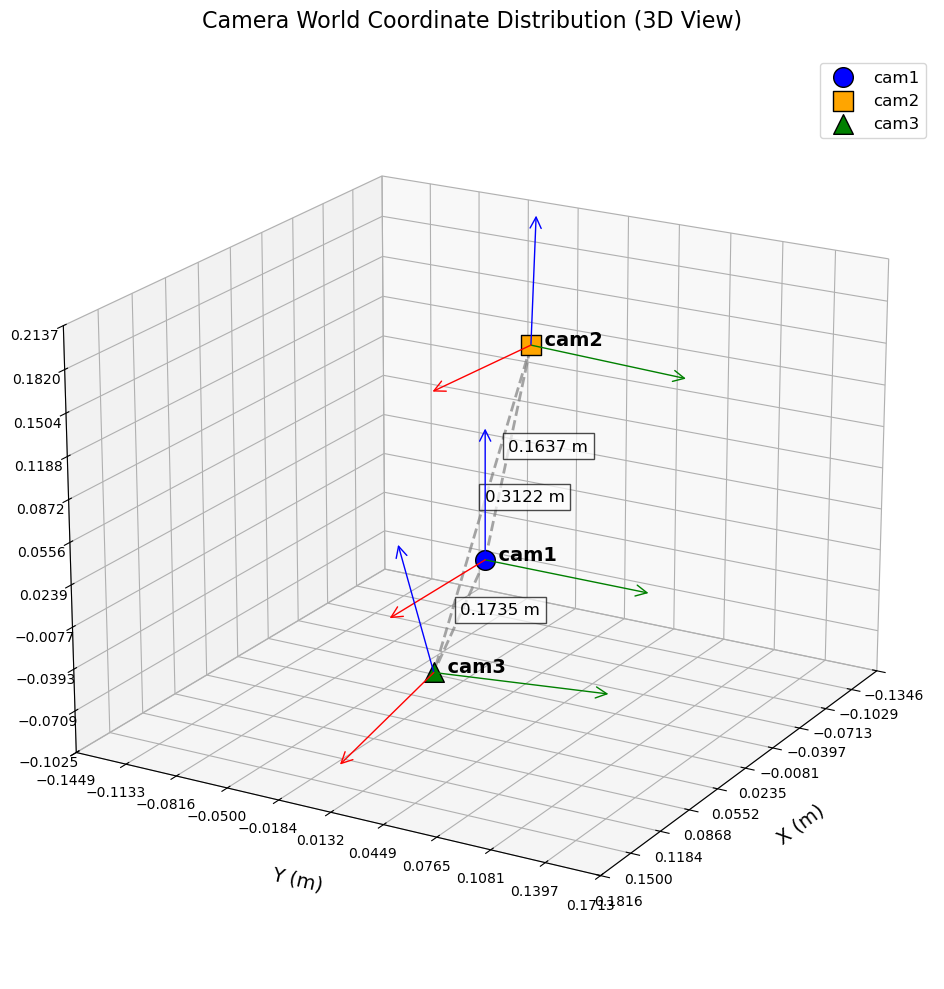

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import pickle

# 創建3D箭頭
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# 載入相機外參數
with open('camera_extrinsics.pkl', 'rb') as f:
    camera_extrinsics = pickle.load(f)

# 設置圖形大小和解析度
fig = plt.figure(figsize=(12, 10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# 相機顏色和標記
colors = {'cam1': 'blue', 'cam2': 'orange', 'cam3': 'green'}
markers = {'cam1': 'o', 'cam2': 's', 'cam3': '^'}
marker_sizes = {'cam1': 200, 'cam2': 200, 'cam3': 200}

# 繪製相機位置
for cam_name, data in camera_extrinsics.items():
    pos = data["world_position"].flatten()
    ax.scatter(pos[0], pos[1], pos[2], 
               s=marker_sizes[cam_name], 
               color=colors[cam_name], 
               marker=markers[cam_name], 
               label=cam_name,
               edgecolors='black')
    
    # 標記相機名稱
    ax.text(pos[0], pos[1], pos[2], 
            f"  {cam_name}", 
            fontsize=14,
            fontweight='bold')
    
    # 為每個相機繪製坐標軸
    scale = 0.1  # 坐標軸長度
    R = data["R"]
    
    # 相機坐標系的三個軸
    x_axis = R[:,0] * scale
    y_axis = R[:,1] * scale
    z_axis = R[:,2] * scale
    
    # 繪製坐標軸
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
    
    a = Arrow3D([pos[0], pos[0]+x_axis[0]], 
                [pos[1], pos[1]+x_axis[1]], 
                [pos[2], pos[2]+x_axis[2]], 
                **arrow_prop_dict, color='red')
    ax.add_artist(a)
    
    a = Arrow3D([pos[0], pos[0]+y_axis[0]], 
                [pos[1], pos[1]+y_axis[1]], 
                [pos[2], pos[2]+y_axis[2]], 
                **arrow_prop_dict, color='green')
    ax.add_artist(a)
    
    a = Arrow3D([pos[0], pos[0]+z_axis[0]], 
                [pos[1], pos[1]+z_axis[1]], 
                [pos[2], pos[2]+z_axis[2]], 
                **arrow_prop_dict, color='blue')
    ax.add_artist(a)

# 繪製相機間的連線
cam_positions = {}
for cam_name, data in camera_extrinsics.items():
    cam_positions[cam_name] = data["world_position"].flatten()

# 繪製所有相機之間的連線
for i, cam1 in enumerate(cam_positions.keys()):
    for cam2 in list(cam_positions.keys())[i+1:]:
        pos1 = cam_positions[cam1]
        pos2 = cam_positions[cam2]
        
        # 連線
        ax.plot([pos1[0], pos2[0]], 
                [pos1[1], pos2[1]], 
                [pos1[2], pos2[2]], 
                '--', 
                color='gray', 
                linewidth=2, 
                alpha=0.7)
        
        # 計算距離
        distance = np.linalg.norm(pos1 - pos2)
        
        # 連線中點
        mid_point = (pos1 + pos2) / 2
        
        # 顯示距離
        ax.text(mid_point[0], mid_point[1], mid_point[2], 
                f"{distance:.4f} m", 
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7))

# 設置坐標軸範圍
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

# 找到最大範圍
max_range = max(x_max-x_min, y_max-y_min, z_max-z_min)
mid_x = (x_max + x_min) / 2
mid_y = (y_max + y_min) / 2
mid_z = (z_max + z_min) / 2

# 設置新的範圍
ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

# 設置標籤和標題
ax.set_xlabel("X (m)", fontsize=14, labelpad=15)
ax.set_ylabel("Y (m)", fontsize=14, labelpad=15)
ax.set_zlabel("Z (m)", fontsize=14, labelpad=15)
ax.set_title("Camera World Coordinate Distribution (3D View)", fontsize=16, pad=20)

# 添加網格
ax.grid(True)

# 添加坐標軸
x_minor_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 11)
y_minor_ticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 11)
z_minor_ticks = np.linspace(ax.get_zlim()[0], ax.get_zlim()[1], 11)

ax.set_xticks(x_minor_ticks)
ax.set_yticks(y_minor_ticks)
ax.set_zticks(z_minor_ticks)

# 調整視角
ax.view_init(elev=20, azim=30)

# 添加圖例
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()

# 保存高解析度圖片
plt.savefig('camera_positions_3d_enhanced.png', dpi=300, bbox_inches='tight')

# 顯示圖形
plt.show()


以cam1為原點，其兩台cam與漆彈槍槍口中心位置

載入相機外參數: camera_extrinsics.pkl
成功載入相機外參數
載入標記ID 19的位置資料: ArUco\marker_19_position.json
成功載入標記ID 19的位置資料
標記ID: 19
位置: [-0.1320909410350605, -0.04076831327579658, 2.345379287680958]
使用相機對: ['cam1', 'cam2']


C:\Users\landis\AppData\Local\Temp\ipykernel_25496\3192034862.py:329: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
C:\Users\landis\AppData\Local\Temp\ipykernel_25496\3192034862.py:329: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')


已保存圖片至: ArUco\camera_positions_with_marker_id19.png


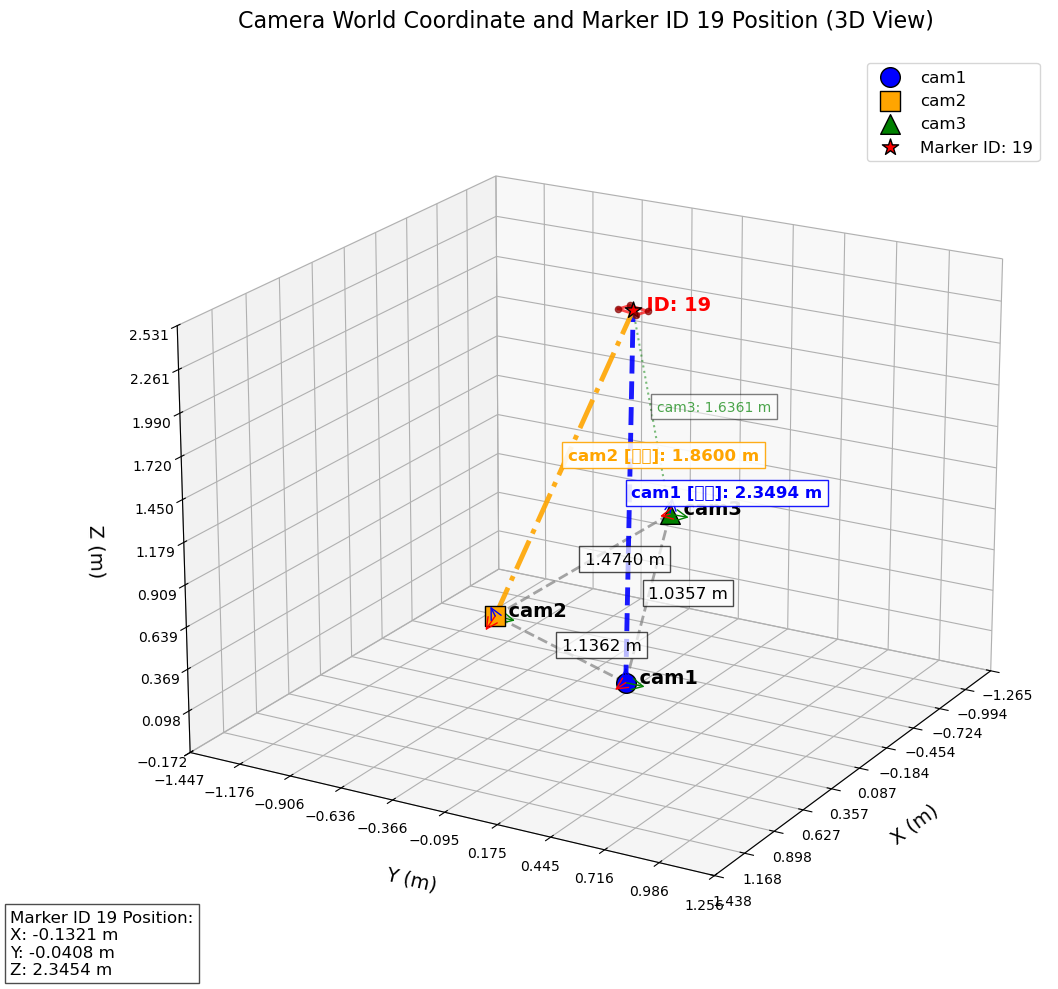

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import pickle
import json
import os

# 創建3D箭頭
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# 定義檔案路徑
extrinsics_path = 'camera_extrinsics.pkl'
marker_json_path = 'ArUco\marker_19_position.json'

# 載入相機外參數
print(f"載入相機外參數: {extrinsics_path}")
try:
    with open(extrinsics_path, 'rb') as f:
        camera_extrinsics = pickle.load(f)
    print("成功載入相機外參數")
except Exception as e:
    print(f"無法載入相機外參數: {str(e)}")
    # 使用預設外參數
    camera_extrinsics = {
        "cam1": {
            "R": np.eye(3),  # Identity matrix
            "t": np.zeros((3, 1)),
            "world_position": np.zeros(3)
        },
        "cam2": {
            "R": np.array([
                [0.887563681516768, -0.06498120868445097, -0.4560791091140977],
                [0.01989642659025889, 0.9944852144740493, -0.1029722797719987],
                [0.46025519384504454, 0.08232011121477036, 0.8839618520209163]
            ]),
            "t": np.array([[0.34078242881314713], [0.04761024768872124], [0.012483457073320547]]),
            "world_position": np.array([-0.34078242881314713, -0.04761024768872124, -0.012483457073320547])
        },
        "cam3": {
            "R": np.array([
                [0.92375102425727, 0.03736752106483449, 0.3811662544784278],
                [0.0002655522715404039, 0.9951662310303017, -0.09820438940767914],
                [-0.38299343945508457, 0.09081762486661484, 0.9192759021903877]
            ]),
            "t": np.array([[0.2871955831333205], [-0.022333983890292203], [0.013784899909049964]]),
            "world_position": np.array([-0.2871955831333205, 0.022333983890292203, -0.013784899909049964])
        }
    }

# 載入標記ID 19的位置資料
print(f"載入標記ID 19的位置資料: {marker_json_path}")
try:
    with open(marker_json_path, 'r') as f:
        marker_data = json.load(f)
    print("成功載入標記ID 19的位置資料")
    
    print(f"標記ID: {marker_data['marker_id']}")
    print(f"位置: {marker_data['position']}")
    print(f"使用相機對: {marker_data['cam_pair']}")
    
    # 從JSON中獲取資料
    marker_position = np.array(marker_data["position"])
    corners_3d = np.array(marker_data["corners_3d"])
    cam_pair = marker_data["cam_pair"]
    
except Exception as e:
    print(f"無法載入標記位置資料: {str(e)}")
    # 使用預設標記資料
    marker_id = 19
    marker_position = np.array([-0.16367318209427553, -0.07833189209413982, 0.7441421526465141])
    corners_3d = np.array([
              [-0.2112619126118886, -0.028469267909478176, 0.7279933328241592],
              [-0.213305658479353, -0.12826059724074482, 0.7371747035686851],
              [-0.11615535749082577, -0.12802862930770403, 0.7597318960002869],
              [-0.11396979979503474, -0.02856907391863229,0.7516686781929248]
              ])
    cam_pair = ["cam1", "cam2"]  # 預設使用相機對

# 包含所有相機
all_cameras = ["cam1", "cam2", "cam3"]

# 設置圖形大小和解析度
fig = plt.figure(figsize=(12, 10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# 相機顏色和標記
colors = {'cam1': 'blue', 'cam2': 'orange', 'cam3': 'green'}
markers = {'cam1': 'o', 'cam2': 's', 'cam3': '^'}
marker_sizes = {'cam1': 200, 'cam2': 200, 'cam3': 200}

# 繪製相機位置
for cam_name, data in camera_extrinsics.items():
    # 確保world_position存在
    if "world_position" not in data:
        # 不存在，從R和t計算
        data["world_position"] = -data["R"].T @ data["t"]
        if isinstance(data["world_position"], np.ndarray) and len(data["world_position"].shape) > 1:
            data["world_position"] = data["world_position"].flatten()
    
    pos = data["world_position"].flatten()
    ax.scatter(pos[0], pos[1], pos[2], 
               s=marker_sizes[cam_name], 
               color=colors[cam_name], 
               marker=markers[cam_name], 
               label=cam_name,
               edgecolors='black')
    
    # 相機名稱
    ax.text(pos[0], pos[1], pos[2], 
            f"  {cam_name}", 
            fontsize=14,
            fontweight='bold')
    
    # 繪製相機坐標軸
    scale = 0.1  # 坐標軸長度
    R = data["R"]
    
    # 相機坐標系的三個軸
    x_axis = R[:,0] * scale
    y_axis = R[:,1] * scale
    z_axis = R[:,2] * scale
    
    # 繪製坐標軸
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
    
    a = Arrow3D([pos[0], pos[0]+x_axis[0]], 
                [pos[1], pos[1]+x_axis[1]], 
                [pos[2], pos[2]+x_axis[2]], 
                **arrow_prop_dict, color='red')
    ax.add_artist(a)
    
    a = Arrow3D([pos[0], pos[0]+y_axis[0]], 
                [pos[1], pos[1]+y_axis[1]], 
                [pos[2], pos[2]+y_axis[2]], 
                **arrow_prop_dict, color='green')
    ax.add_artist(a)
    
    a = Arrow3D([pos[0], pos[0]+z_axis[0]], 
                [pos[1], pos[1]+z_axis[1]], 
                [pos[2], pos[2]+z_axis[2]], 
                **arrow_prop_dict, color='blue')
    ax.add_artist(a)

# 繪製相機間的連線
cam_positions = {}
for cam_name, data in camera_extrinsics.items():
    cam_positions[cam_name] = data["world_position"].flatten()

# 繪製所有相機之間的連線
for i, cam1 in enumerate(cam_positions.keys()):
    for cam2 in list(cam_positions.keys())[i+1:]:
        pos1 = cam_positions[cam1]
        pos2 = cam_positions[cam2]
        
        # 連線
        ax.plot([pos1[0], pos2[0]], 
                [pos1[1], pos2[1]], 
                [pos1[2], pos2[2]], 
                '--', 
                color='gray', 
                linewidth=2, 
                alpha=0.7)
        
        # 計算距離
        distance = np.linalg.norm(pos1 - pos2)
        
        # 連線中點
        mid_point = (pos1 + pos2) / 2
        
        # 顯示距離
        ax.text(mid_point[0], mid_point[1], mid_point[2], 
                f"{distance:.4f} m", 
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7))

# 繪製標記ID 19的中心點
marker_id = 19
ax.scatter(marker_position[0], marker_position[1], marker_position[2], 
           s=150, color='red', marker='*', label=f'Marker ID: {marker_id}',
           edgecolors='black', zorder=10)

# 標記ID
ax.text(marker_position[0], marker_position[1], marker_position[2], 
        f"  ID: {marker_id}", 
        fontsize=14,
        fontweight='bold',
        color='red')

# 繪製標記的四個角點
for i, corner in enumerate(corners_3d):
    ax.scatter(corner[0], corner[1], corner[2], 
               s=80, color='darkred', marker='.', alpha=0.7)
    
    # 連接角點
    next_idx = (i + 1) % 4
    ax.plot([corners_3d[i][0], corners_3d[next_idx][0]],
            [corners_3d[i][1], corners_3d[next_idx][1]],
            [corners_3d[i][2], corners_3d[next_idx][2]],
            'r-', linewidth=2, alpha=0.7)

# 連接標記與所有三台相機
line_styles = ['--', '-.', ':']  

used_cameras = []
if isinstance(cam_pair, list):
    used_cameras = cam_pair
elif isinstance(cam_pair, tuple):
    used_cameras = list(cam_pair)

# 先繪製三角測量的相機對
for idx, cam_name in enumerate(used_cameras):
    if cam_name in cam_positions:
        cam_pos = cam_positions[cam_name]
        line_color = colors[cam_name]
        
        # 使用粗線標示用於三角測量的相機
        ax.plot([cam_pos[0], marker_position[0]],
                [cam_pos[1], marker_position[1]],
                [cam_pos[2], marker_position[2]],
                line_styles[idx % len(line_styles)], 
                color=line_color, 
                linewidth=3.5,  
                alpha=0.9)     
        
        # 計算距離
        distance = np.linalg.norm(cam_pos - marker_position)
        
        # 連線中點
        mid_point = (cam_pos + marker_position) / 2
        offset = np.array([0.02, 0.02, 0.02]) * (idx + 1)
        mid_point = mid_point + offset
        
        ax.text(mid_point[0], mid_point[1], mid_point[2], 
                f"{cam_name} [測量]: {distance:.4f} m", 
                fontsize=12,
                color=line_color,
                weight='bold',
                bbox=dict(facecolor='white', alpha=0.9, edgecolor=line_color))

# 未用於測量的相機
unused_cameras = [cam for cam in all_cameras if cam not in used_cameras]
for idx, cam_name in enumerate(unused_cameras):
    if cam_name in cam_positions:
        cam_pos = cam_positions[cam_name]
        line_color = colors[cam_name]
        
        ax.plot([cam_pos[0], marker_position[0]],
                [cam_pos[1], marker_position[1]],
                [cam_pos[2], marker_position[2]],
                ':', 
                color=line_color, 
                linewidth=1.5,  
                alpha=0.5)      
        
        # 計算距離
        distance = np.linalg.norm(cam_pos - marker_position)
        
        # 連線中點
        mid_point = (cam_pos + marker_position) / 2
        offset = np.array([0.02, 0.02, 0.02]) * (idx + 1 + len(used_cameras))
        mid_point = mid_point + offset
        
        # 顯示未用於測量的相機
        ax.text(mid_point[0], mid_point[1], mid_point[2], 
                f"{cam_name}: {distance:.4f} m", 
                fontsize=10,
                color=line_color,
                alpha=0.7,
                bbox=dict(facecolor='white', alpha=0.5))

# 設置坐標軸範圍
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

# 找到最大範圍
max_range = max(x_max-x_min, y_max-y_min, z_max-z_min)
mid_x = (x_max + x_min) / 2
mid_y = (y_max + y_min) / 2
mid_z = (z_max + z_min) / 2

# 設置新的範圍
ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

# 設置標籤和標題
ax.set_xlabel("X (m)", fontsize=14, labelpad=15)
ax.set_ylabel("Y (m)", fontsize=14, labelpad=15)
ax.set_zlabel("Z (m)", fontsize=14, labelpad=15)
ax.set_title("Camera World Coordinate and Marker ID 19 Position (3D View)", fontsize=16, pad=20)

# 添加標記詳細資訊
info_text = f"Marker ID 19 Position:\nX: {marker_position[0]:.4f} m\nY: {marker_position[1]:.4f} m\nZ: {marker_position[2]:.4f} m"
plt.figtext(0.02, 0.02, info_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# 添加網格
ax.grid(True)

# 添加坐標軸
x_minor_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 11)
y_minor_ticks = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 11)
z_minor_ticks = np.linspace(ax.get_zlim()[0], ax.get_zlim()[1], 11)

ax.set_xticks(x_minor_ticks)
ax.set_yticks(y_minor_ticks)
ax.set_zticks(z_minor_ticks)

ax.view_init(elev=20, azim=30)

# 添加圖例
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()

# 保存圖片
output_path = 'ArUco\camera_positions_with_marker_id19.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"已保存圖片至: {output_path}")

# 顯示圖形
plt.show()